In [23]:
# import necessary packages
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# updates methods and classes from external files in the notebook 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: 'Image' object has no attribute 'squeeze'

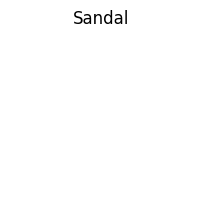

In [25]:
# import FashionMNIST dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    # transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    # transform=ToTensor()
)

# labels for the dataset
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [21]:
print(len(train_data))
len(train_data.attr_names)


162770


41

torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])


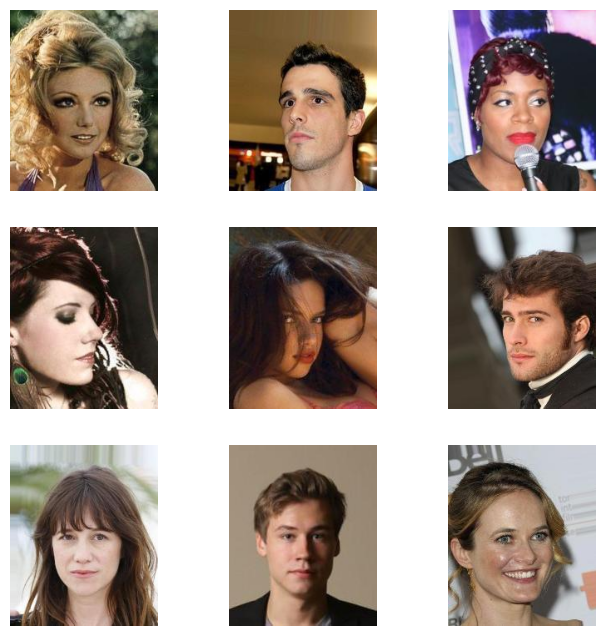

In [20]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    # plt.title(label)
    print(label.shape)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()